In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Data Set Split
from sklearn.model_selection import StratifiedShuffleSplit

# Correlations
import seaborn as sns

# Models
# R2 score
from sklearn.metrics import r2_score
# Linear Regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# KN Regressor
from sklearn.neighbors import KNeighborsRegressor
# Grid Search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras_tuner.tuners import RandomSearch

# Запись времени
import time

# Возможные улучшения:
# TODO # Classification precision and recall \ # Regression MAYA
# TODO Если точность 99.99 = оверфит надо крутить параметры "pruning" \ max depth
# TODO RAY TUNING (OPTUNA) https://madewithml.com/courses/mlops/tuning/
# TODO Удалить после тренинга и предикта все данные больше 20%точности и меньше 80%точности и потом на новом дата сете провести evaluation

# Data Analysis

In [126]:
# np.set_printoptions - это функция NumPy, которая позволяет настроить способ отображения массивов при печати. В данном случае, с аргументами precision=2 и suppress=True, вы устанавливаете следующие параметры:
#
# precision=2: Устанавливает точность вывода чисел с плавающей запятой до двух знаков после запятой.
# suppress=True: Подавляет использование научной нотации для очень маленьких чисел в выводе.
# Эти настройки позволяют выводить числа массива с ограниченной точностью до двух знаков после запятой без научной нотации. Это может быть полезно для улучшения читаемости вывода данных, особенно если у вас есть большие массивы чисел с плавающей запятой.


np.set_printoptions(precision=2, suppress=True)

In [127]:
# Загружаем набор данных с помощью pandas
data = pd.read_csv("data.csv")

In [128]:
# Выводим первые 10 значений набора данных
data.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [129]:
# Получаем общую информацию о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [130]:
# Получаем статистику по набору данных. Для понимания с какими данными мы будем работать
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


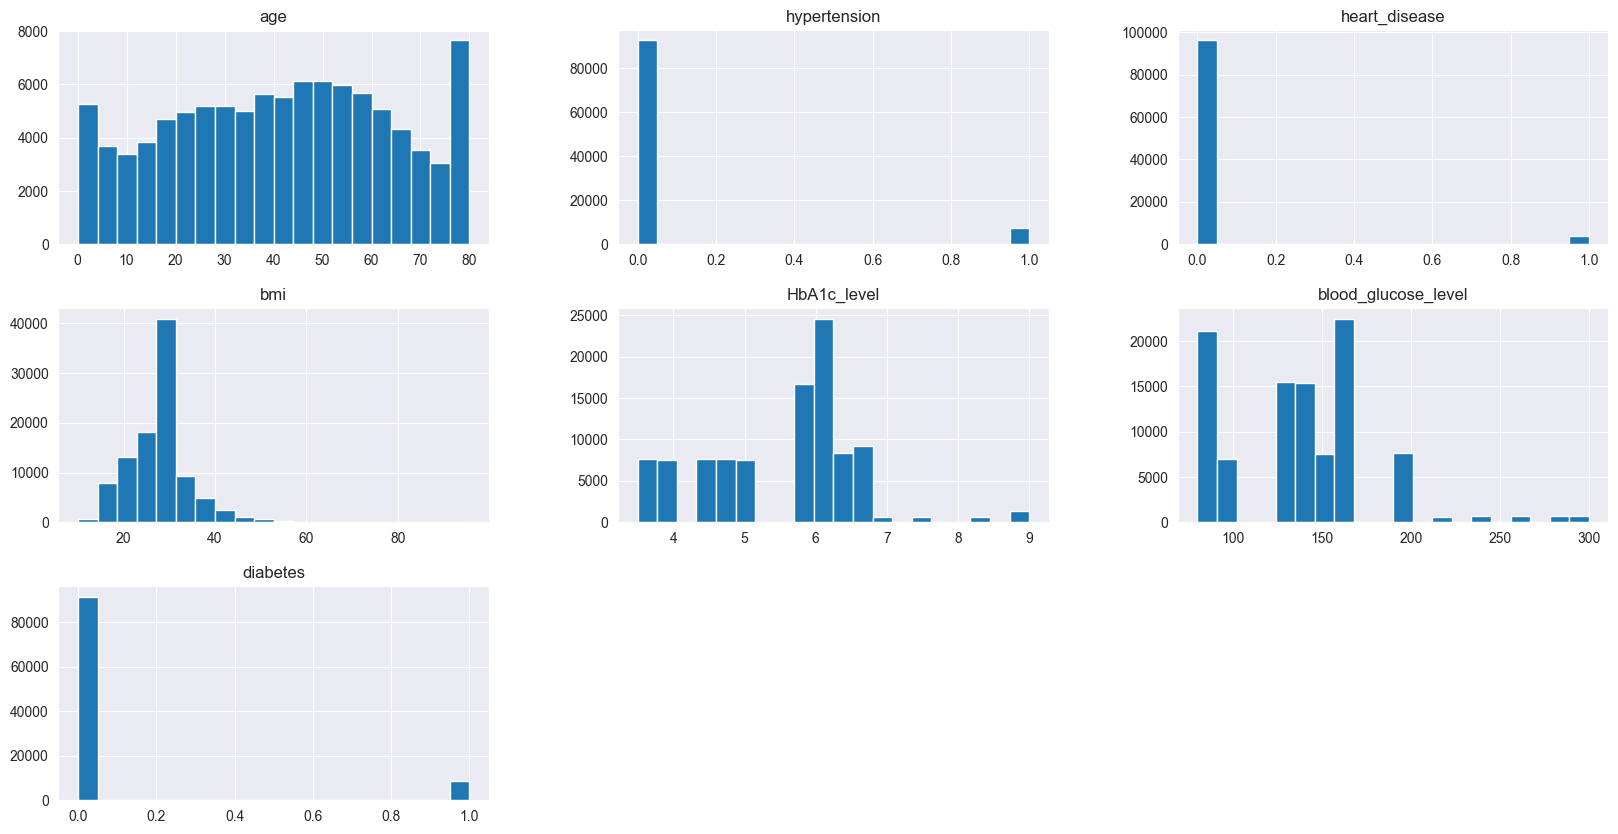

In [131]:
# Визуализируем набор всех фич набора данных + наличие диабета
data.hist(bins=20, figsize=(20, 10))
plt.show()

# Data Preprocessing

In [132]:
# Найдем все столбцы с null значениями
cols_with_missing_values = data.columns[data.isnull().any()]

# Визуально определяем столбцы с пропущенными значениями
print(data.isnull().any())

# Заменим эти значения средним
data[cols_with_missing_values] = data[cols_with_missing_values].apply(lambda col: col.fillna(data[col.name].mean()))

gender                 False
age                    False
hypertension           False
heart_disease          False
smoking_history        False
bmi                    False
HbA1c_level            False
blood_glucose_level    False
diabetes               False
dtype: bool


In [133]:
# Находим неверные значения и заменяем их средними
values = ['Male', 'Female']
data.loc[data["gender"] == "Other", "gender"] = random.choice(values)

# Преобразуем категориальные значения в числа с помощью map
# Для этих задач отлично подходит код ниже, но мы делаем это вручную.
# data["smoking_history"] = LabelEncoder().fit_transform(data["smoking_history"])
# print(data['smoking_history'])

# Дадим значения полам
mapping = {'Female': 0, 'Male': 1}
data['gender'] = data['gender'].map(mapping)

# Определим историю курения
mapping = {'never': 0, 'current': 1, 'No Info': 0, 'former': 0.5, "ever": 0.1, "not current": 0.2}
data['smoking_history'] = data['smoking_history'].map(mapping)

# Изменим ml\ds на mmol\l
data['blood_glucose_level'] = data['blood_glucose_level'] * 0.056

# Data Correlations

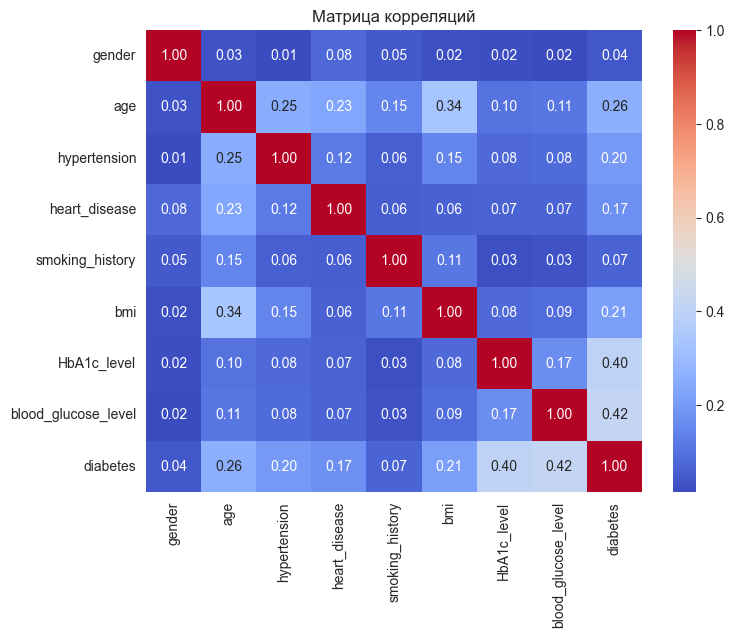

In [134]:
correlation_matrix = data.corr().abs()

# Визуализация матрицы корреляций с помощью heatmap из библиотеки Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

In [135]:
# Зависимости значений к наличию диабета.
correlation_matrix["diabetes"].sort_values(ascending=False)

diabetes               1.000000
blood_glucose_level    0.419558
HbA1c_level            0.400660
age                    0.258008
bmi                    0.214357
hypertension           0.197823
heart_disease          0.171727
smoking_history        0.069648
gender                 0.037666
Name: diabetes, dtype: float64

# Stratification

In [136]:
# Определяем каждой колонке прономерованную по группам, с суффиксом _labeled
columns = data.columns
for column in columns:
    data[column+"_labeled"] = pd.qcut(data[column], q=5, labels=False, duplicates='drop')

# Подсчет количества уникальных значений в каждом новом столбце labeled
unique_counts = data.filter(like="_labeled").nunique()

# Получение названий столбцов с одним уникальным значением
single_label_columns = unique_counts[unique_counts <= 2].index

# Удаление столбцов с одним уникальным значением
data = data.drop(columns=single_label_columns)

### Выводим все столбцы, чтобы определить, по каким данным будем стратифицировать

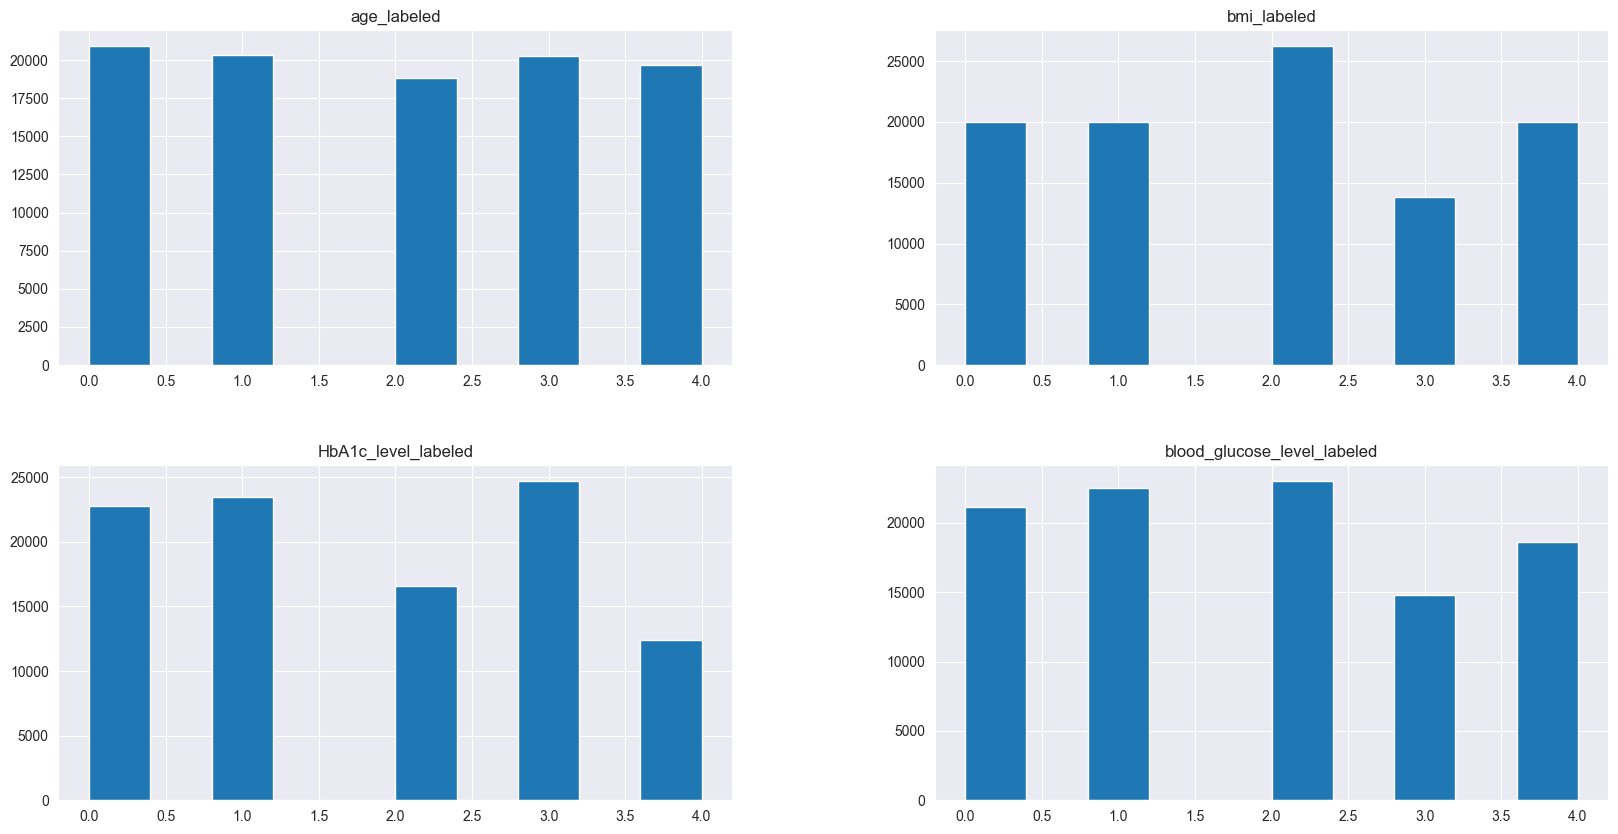

In [137]:
# Находим столбцы с суффиксом _labeled и выводим их для сравнения корреляции данных
labeled_columns = [col for col in data.columns if col.endswith("_labeled")]

data[labeled_columns].hist(figsize=(20, 10))
plt.show()

# Data Set Split

Разбивает данные таким образом, чтобы распределение значений целевой переменной было сбалансированным как в обучающем, так и в тестовом наборах.

In [138]:
# Разбиваем данные на обучающие и тестовые в соотношении 80\20 и с использованием стратификации по столбцу current_column
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=22)

current_column = "age_labeled"

for train_index, test_index in split.split(data, data[current_column]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [139]:
# Сравниваем результаты применения StratifiedShuffleSplit функции
test_strat = strat_test_set[current_column].value_counts() / len(strat_test_set)
data_set = data[current_column].value_counts() / len(strat_test_set)
train_strat = strat_train_set[current_column].value_counts() / len(strat_train_set)

print(f"\nOriginal Data: \n{data_set}\n\nTrain: \n{train_strat}\n\nTest: \n{test_strat}")


Original Data: 
age_labeled
0    1.04520
1    1.01705
3    1.01260
4    0.98330
2    0.94185
Name: count, dtype: float64

Train: 
age_labeled
0    0.209037
1    0.203412
3    0.202513
4    0.196662
2    0.188375
Name: count, dtype: float64

Test: 
age_labeled
0    0.20905
1    0.20340
3    0.20255
4    0.19665
2    0.18835
Name: count, dtype: float64


In [140]:
# Удаляем столбец с labels, так как он может мешать обучению и в целом не нужен.
for labeled in labeled_columns:
    if labeled in strat_train_set:
        strat_train_set = strat_train_set.drop(labeled,axis=1)
        strat_test_set = strat_test_set.drop(labeled,axis=1)
        data = data.drop(labeled, axis=1)
    else:
        print(f"Столбец {labeled} уже удален")

In [141]:
# Определяем рабочую переменную с обучающими данными и тестовыми
train_data = strat_train_set.copy()
test_data = strat_test_set.copy()

In [142]:
# split into input and output columns
X_train = train_data.values[:, :-1]
y_train = train_data.values[:, -1]

# split into input and output columns
X_test = test_data.values[:, :-1]
y_test = test_data.values[:, -1]

In [143]:
# Определяем количество фич (Термин "фичи" относится к характеристикам или переменным, используемым для описания каждого образца в наборе данных. Например, если у вас есть данные о покупках, фичами могут быть цена продукта, количество, тип платежа и т. д. ). Столбцов для обучения
n_features = X_train.shape[1]
print(n_features)

8


# Outlier detection

In [144]:
# Update Coming

# Choosing a model to ML solution

In [145]:
models_r2_values = {}

def model_evaluation(model, model_name: str):
    y_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred)
    rmse_train = np.sqrt(mse_train)

    # Оценка модели на тестовых данных
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)

    print(f"\n\n{model_name}\n\n")

    print(np.concatenate((y_pred_test.reshape(len(y_pred_test), 1), y_test.reshape(len(y_test), 1)), 1)[:10])

    print("\nMean squared error on test set: ", mse_test)
    print("Root mean squared error on test set (RMSE): ", rmse_test)

    print("\nMean error: ", mse_train)
    print("Root mean squared error: ", rmse_train)

    difference_mse = (mse_test - mse_train) / mse_train * 100
    difference_rmse = (rmse_test - rmse_train) / rmse_train * 100

    print(f"\nDifferences in MSE (train to test): {difference_mse:.2f}%")
    print(f"Differences in RMSE (train to test): {difference_rmse:.2f}%")

    # Оценка модели на тестовых данных
    """
    Коэффициент R2 измеряет долю дисперсии зависимой переменной (целевой переменной), которая может быть объяснена моделью. Значение R2 находится в диапазоне от 0 до 1, где 1 указывает на то, что модель полностью объясняет изменчивость зависимой переменной, а 0 указывает на то, что модель не объясняет никакой изменчивости.
    """
    r2_test = r2_score(y_test, y_pred_test)
    print(f"\nR-squared test: {r2_test:.4f}")

    r2 = r2_score(y_train, y_pred)
    print(f"R-squared train: {r2:.4f}")


    models_r2_values[model_name] = r2_test

### LinearRegression

In [146]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

model_evaluation(lin_reg, "Линейная Регрессия")



Линейная Регрессия


[[ 0.11  0.  ]
 [-0.11  0.  ]
 [ 0.17  0.  ]
 [ 0.48  1.  ]
 [ 0.33  1.  ]
 [ 0.1   0.  ]
 [ 0.43  1.  ]
 [ 0.14  0.  ]
 [ 0.08  0.  ]
 [-0.05  0.  ]]

Mean squared error on test set:  0.050954700385011695
Root mean squared error on test set (RMSE):  0.22573147849826283

Mean error:  0.05060175494611633
Root mean squared error:  0.22494833839376616

Differences in MSE (train to test): 0.70%
Differences in RMSE (train to test): 0.35%

R-squared test: 0.3582
R-squared train: 0.3460


### DecisionTreeRegressor

In [147]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

model_evaluation(tree_reg, "Дерево Решений")



Дерево Решений


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Mean squared error on test set:  0.04725834375
Root mean squared error on test set (RMSE):  0.21738984279399992

Mean error:  0.0007097767857142857
Root mean squared error:  0.02664163631825729

Differences in MSE (train to test): 6558.20%
Differences in RMSE (train to test): 715.98%

R-squared test: 0.4047
R-squared train: 0.9908


### KNeighborsRegressor

In [148]:
knn = KNeighborsRegressor(n_neighbors=2, metric='minkowski', p=2)  # minkowski
knn.fit(X_train, y_train)

model_evaluation(knn, "КНН")



КНН


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Mean squared error on test set:  0.043375
Root mean squared error on test set (RMSE):  0.20826665599658528

Mean error:  0.014284375
Root mean squared error:  0.11951725816801521

Differences in MSE (train to test): 203.65%
Differences in RMSE (train to test): 74.26%

R-squared test: 0.4536
R-squared train: 0.8154


### RandomForestRegressor \ GridSearchCV

In [149]:
# Запоминаем время начала выполнения кода
start_time = time.time()

param_grid = [
    {'n_estimators': [10, 30, 60, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,  # it will train each model five times
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

{'max_features': 2, 'n_estimators': 100}


In [150]:
for_reg = RandomForestRegressor(**best_params, criterion='squared_error',
                                random_state=0)  # n_estimators - кількість дерев у лісі. criterion - функція вимірювання якості розбиття.
for_reg.fit(X_train, y_train)

model_evaluation(for_reg, "Grid Search")

# Запоминаем время окончания выполнения кода
end_time = time.time()

# Вычисляем время выполнения
execution_time = end_time - start_time

print(f"Время выполнения кода: {execution_time / 60} минут")



Grid Search


[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [1.   1.  ]
 [1.   1.  ]
 [0.05 0.  ]
 [1.   1.  ]
 [0.01 0.  ]
 [0.   0.  ]
 [0.   0.  ]]

Mean squared error on test set:  0.024940668620135716
Root mean squared error on test set (RMSE):  0.15792614926013904

Mean error:  0.00401134765141068
Root mean squared error:  0.06333520072922072

Differences in MSE (train to test): 521.75%
Differences in RMSE (train to test): 149.35%

R-squared test: 0.6858
R-squared train: 0.9482
Время выполнения кода: 5.23989265759786 минут


# Neural Network Creation and Tuning

In [151]:
def build_model(hp):
    model = Sequential()

    model.add(Dense(units=hp.Int('units1', min_value=10, max_value=100, step=10),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(n_features,)))
    model.add(Dense(units=hp.Int('units2', min_value=1, max_value=10, step=1),
                    activation='relu',
                    kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

    # Include epochs and batch_size directly in the fit function
    model.fit(X_train, y_train, epochs=hp.Int('epochs', min_value=3, max_value=10),
              batch_size=hp.Int('batch_size', min_value=8, max_value=128, step=16),
              validation_data=(X_train, y_train),
              verbose=0)  # Set verbose to 1 for more detailed output during the search

    return model

In [152]:
# Instantiate the tuner and perform the search
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=12,  # Adjust as needed
                     directory='classification_diabetes_model',  # Change to a directory of your choice
                     project_name='diabetes_recognition',
                     overwrite=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_train, y_train), verbose=1)

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

Trial 12 Complete [00h 00m 18s]
val_accuracy: 0.91548752784729

Best val_accuracy So Far: 0.9642999768257141
Total elapsed time: 00h 08m 35s


In [153]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print("units1:", best_hps.get('units1'))
print("units2:", best_hps.get('units2'))
print("epochs:", best_hps.get('epochs'))
print("batch_size:", best_hps.get('batch_size'))

Best Hyperparameters:
units1: 40
units2: 10
epochs: 10
batch_size: 40


# Model Creation with Tuned parameters

In [154]:
# Запоминаем время начала выполнения кода
start_time = time.time()
# Определяем что наша модель последовательная. Т.е. мы добавляем слои один за другим.
model = Sequential()
# Создаем 3 слоя на 10, 8 и 1 нейрон.
model.add(Dense(best_hps.get('units1'), activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(best_hps.get('units2'), activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
# Берем тренировочные данные. Устанавливаем количество эпох, вводим размер батча и устанавливаем правило вывода. verbose=1 выводить данные по каждой эпохе, =0 не выводить.
model.fit(X_train, y_train, epochs=best_hps.get('epochs'), batch_size=best_hps.get('batch_size'), verbose=1)

model_evaluation(model, "Нейросеть")

# Запоминаем время окончания выполнения кода
end_time = time.time()

# Вычисляем время выполнения
execution_time = end_time - start_time

print(f"Время выполнения кода: {execution_time / 60} минут")

Epoch 1/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2603 - accuracy: 0.9248
Epoch 2/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2006 - accuracy: 0.9344
Epoch 3/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1688 - accuracy: 0.9429
Epoch 4/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.1451 - accuracy: 0.9500
Epoch 5/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.1360 - accuracy: 0.9535
Epoch 6/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.1311 - accuracy: 0.9553
Epoch 7/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1267 - accuracy: 0.9566
Epoch 8/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1247 - accuracy: 0.9572
Epoch 9/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1247 - accuracy: 0.9571
Epoch 10/10
625/625 [==============================] - 1s 956us/step


Нейросеть



In [155]:
# Высчитываем точность модели, сравнивая
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {acc * 100}')

625/625 [==============================] - 1s 1ms/step - loss: 0.1227 - accuracy: 0.9564
Test Accuracy: 95.6350028514862


# SVC model creation without tuning

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     18261
         1.0       0.97      0.60      0.74      1739

    accuracy                           0.96     20000
   macro avg       0.97      0.80      0.86     20000
weighted avg       0.96      0.96      0.96     20000



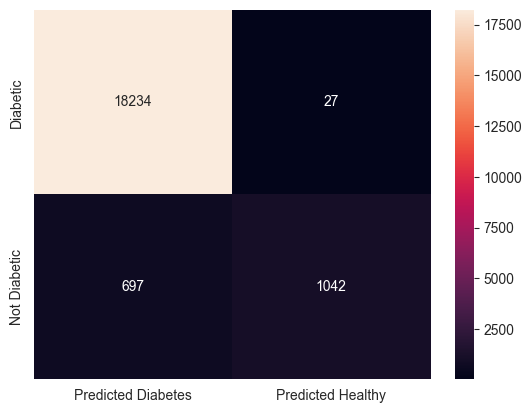

In [156]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler().fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

from sklearn.svm import SVC
svc_model = SVC()

svc_model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
kernel='rbf', max_iter=-1, probability=False, random_state=None,
shrinking=True, tol=0.001, verbose=False)

y_predict = svc_model.predict(x_test)

# aaa = pd.DataFrame(["1", "19", "0", "0", "0", "20", "5", "120"])
# x_qwer = svc_model.predict([1, aaa])

from sklearn.metrics import classification_report, confusion_matrix
cm = np.array(confusion_matrix(y_test, y_predict, labels=[0,1]))
confusion = pd.DataFrame(cm, index=['Diabetic', 'Not Diabetic'], columns=['Predicted Diabetes', 'Predicted Healthy'])
sns.heatmap(confusion,annot=True,fmt='g')

print(classification_report(y_test, y_predict))

### Watch the results for each model

In [157]:
# Создание DataFrame из словаря
df = pd.DataFrame(list(models_r2_values.items()), columns=['Model Name', 'R2'])

# Вывод DataFrame
print(f"Результаты: \n{df}")

Результаты: 
           Model Name        R2
0  Линейная Регрессия  0.358170
1      Дерево Решений  0.404730
2                 КНН  0.453644
3         Grid Search  0.685845
4           Нейросеть  0.564867


## Neural Network Predictions

In [158]:
new_data = ["1", #Введите пол Female or Male \ 0 or 1
            "29", #Введите возраст 10.0
            "1", #'hypertension'0 or 1,
            "1", #'heart_disease'0 or 1,
            "1", #'smoking_history' never, ever, current, not current
            "22.92", #'bmi'10.0,
            "6.5", #'HbA1c_level'10.0,
            "10.5" ] #'blood_glucose_level' mmol 6.2 or md\dl
# data_process(new_data)

# строки в числа с плавающей запятой
new_data_numeric = np.array(new_data, dtype=float)

#
new_data_numeric = new_data_numeric.reshape(1, -1)  # Изменяем форму на (1, num_features)

#
prediction = model.predict(new_data_numeric)

#
print("Предсказанная вероятность:", prediction * 100)

# Определите классификацию на основе порога
if 0.5 <= prediction <= 0.6:
    print("Человек вероятно заболеет диабетом, в течении 5-10 лет")
elif 0.61 <= prediction <= 0.8:
    print("Человек вероятно заболеет диабетом, в течении 1-3 лет")
elif 0.81 <= prediction <= 1:
    print("Человек вероятно заболеет диабетом, в течении года.")
    if 0.9 <= prediction <= 1:
        print("Срочно обратитесь к эндокринологу!")
elif 0.3 <= prediction <= 0.49:
    print("Человек не находится в зоне риска, но имеет предрасположенность к развитию заболевания. Или проблем с эндокринной системой.")
elif 0.2 <= prediction <= 0.29:
    print("Человек не находится в зоне риска, но при этом имеет невыраженные проблемы со здоровьем которые могут развиваться.")
else:
    print("Человек не имеет предпосылок к диабету")

1/1 [==============================] - 0s 49ms/step
Предсказанная вероятность: [[74.34]]
Человек вероятно заболеет диабетом, в течении 1-3 лет
